<a href="https://colab.research.google.com/github/brucequz/sionna/blob/main/turbo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install sionna

In [ ]:
import sionna, time
import numpy as np
import tensorflow as tf
from sionna.utils import BinarySource, ebnodb2no, compute_ber, PlotBER
from sionna.fec import turbo, conv
from sionna.mapping import Mapper, Demapper, Constellation, qam
from sionna.channel import AWGN
from tensorflow.keras import Model

In [ ]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

import numpy as np

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

In [ ]:
sionna.config.seed = 41

fb_poly = '1111001' # oct(171)
ff_poly = '1011011' # oct(133)


batch_size = 1000
k = 64
ebn0 = 1.5


b = BinarySource()([batch_size, k])
c = conv.ConvEncoder(gen_poly=[fb_poly, ff_poly], rsc=True)(b)
encoder = turbo.TurboEncoder(gen_poly=[fb_poly, ff_poly], rate=1/2, interleaver_type="3GPP")
c_turbo = encoder(b)
bpsk = Constellation(constellation_type="custom", num_bits_per_symbol=1, initial_value=[-1,1], normalize=True, center=True)
x = Mapper("custom", constellation=bpsk)(c_turbo)
y = AWGN()([x, ebnodb2no(ebn0, 2, 1/2)])
llr = Demapper(demapping_method="maxlog", constellation_type="custom", constellation=bpsk)([y, ebnodb2no(ebn0, 2, 1/2)])
b_hat = turbo.TurboDecoder(encoder=encoder, num_iter=6)(llr)

print(tf.math.reduce_all(tf.math.equal(b,b_hat)))

tf.Tensor(False, shape=(), dtype=bool)


In [ ]:
class E2E(Model):
  def __init__(self):
    super().__init__()
    self.binary_source = BinarySource()
    self.encoder = turbo.TurboEncoder(gen_poly=[fb_poly, ff_poly], rate=1/2, interleaver_type="3GPP")
    self.mapper  = Mapper("custom", constellation=bpsk)
    self.channel = AWGN()
    self.demapper= Demapper(demapping_method="maxlog", constellation_type="custom", constellation=bpsk)
    self.decoder = turbo.TurboDecoder(encoder=encoder, num_iter=6)

  @tf.function(jit_compile=True)
  def call(self, batch_size, ebno_db):
    b = self.binary_source([batch_size, k])
    c = self.encoder(b)
    x = self.mapper(c)
    no = ebnodb2no(ebn0, m, k/n)
    y = self.channel([x, no])
    llr = self.demapper([y, no])
    b_hat = self.decoder(llr)
    return b, b_hat



In [ ]:
e2e = E2E()
m = 2
k = 64
n = 128
start = time.time()
ber = compute_ber(*e2e(batch_size=20000, ebno_db=3))
end = time.time()
print("{:.2f} seconds elapsed".format(end-start))
print(ber)

76.04 seconds elapsed
tf.Tensor(2.5e-05, shape=(), dtype=float64)


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      5.0 | 3.4555e-05 | 1.4423e-03 |         230 |     6656000 |          150 |      104000 |       375.7 |reached target block errors


(<tf.Tensor: shape=(1,), dtype=float64, numpy=array([3.45552885e-05])>,
 <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.00144231])>)

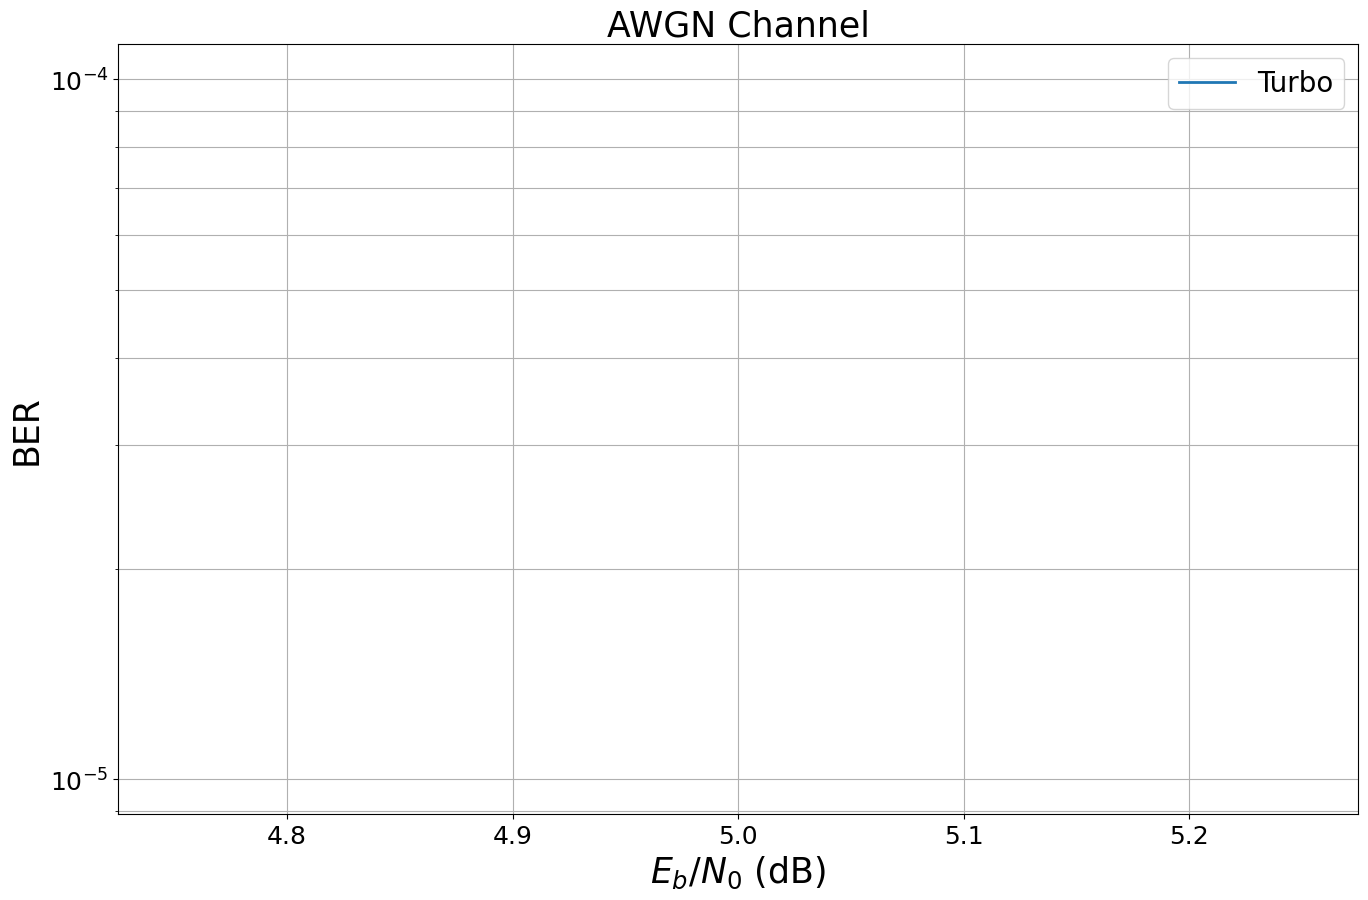

In [ ]:
ber_plot = PlotBER("AWGN Channel")
ber_plot.simulate(
    e2e,
    ebno_dbs=np.arange(5,6),
    batch_size=batch_size,
    num_target_block_errors=150,
    legend="Turbo",
    soft_estimates=False,
    max_mc_iter=1000,
    forward_keyboard_interrupt=False,
    show_fig=True
)